## Figure 5 - Observation of ALOS-2 on Shinmoe-dake and Iwo-yama

In [163]:
%matplotlib inline
import os
import numpy as np
from datetime import timedelta, datetime as dt
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt, ticker, dates as mdates
from mintpy.defaults.plot import *
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy.objects import timeseries
from mintpy import view, tsview

work_dir = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2')
os.chdir(work_dir)
print('Go to directory:', work_dir)

data_dir = os.path.expanduser('~/insarlab/Kirishima/KirishimaAlos2DT23/mintpy')
ts_file = os.path.join(data_dir, 'timeseries_ERA5_ramp_demErr.h5')
mask_file = os.path.join(data_dir, 'maskTempCoh.h5')
dem_file = os.path.join(data_dir, 'inputs/gsi10m.dem.wgs84')
vel_file = os.path.join(data_dir, 'velocity.h5')

lalo_iwo = [31.9502, 130.8548]
lalo_shinmoe = [31.9176, 130.8889]
lalo_ref = [31.9296, 130.8522] #[31.9172, 130.8472]
lalo_list = [lalo_ref, lalo_shinmoe, lalo_iwo]
m_list = ['s','^','D']

Go to directory: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2


save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2/dis_map.png


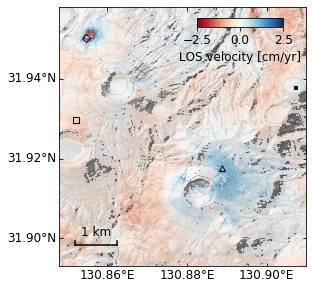

In [226]:
## Plot velocity map
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])

opt = ' --sub-lat 31.893 31.958 --sub-lon 130.848 130.91 '
opt += '--dem {} --contour-step 100 --contour-smooth 0.0 '.format(dem_file)
opt += ' -c RdBu --wrap --wrap-range -2.5 2.5 -u cm/yr '
opt += ' --notitle --fontsize 12 --ref-size 3 --lalo-step 0.02 --nocbar --alpha 0.7 '
opt += ' --lalo-loc 1 0 0 1'
opt += ' --scalebar 0.25 0.15 0.08 --scalebar-pad 0.05 '
opt += ' --noverbose --shade-az 315 '

# velocity map with DEM background
cmd = 'view.py {f} {o}'.format(f=vel_file, o=opt)
data, atr, inps = view.prep_slice(cmd)
ax, inps, im, cbar = view.plot_slice(ax, data, atr, inps)

# point of interest
for lalo, m in zip(lalo_list, m_list):
    ax.plot(lalo[1], lalo[0], "k{}".format(m), mfc='none', mew=1., ms=6)
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# colorbar
#cax = fig.add_axes([0.1, 0.08, 0.03, 0.4])
cax = fig.add_axes([0.55, 0.88, 0.3, 0.03])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')#, ticks=[-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS velocity [cm/yr]', fontsize=font_size)

# output
out_file = os.path.abspath('dis_map.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

In [165]:
## Read displacement time-series at points of interest
obj = timeseries(ts_file)
obj.open()
dates = obj.times
ex_dates = ptime.date_list2vector(ptime.read_date_list(os.path.join(data_dir, 'exclude_date.txt')))[0]
keep_dates = sorted(list(set(dates) - set(ex_dates)))

dis_list = []
for lalo in lalo_list:
    dis = ut.read_timeseries_lalo(lalo[0], lalo[1], ts_file, unit='cm', print_msg=False)[1]
    dis_list.append(dis)

open timeseries file: timeseries_ERA5_ramp_demErr.h5


save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2/dis_ts.png


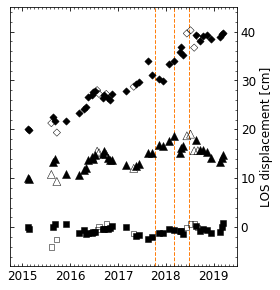

In [205]:
## Plot displacement time-series at points of interest

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3.5, 4])
#fig = plt.figure(figsize=[4, 4])
#gs = GridSpec(3, 1, figure=fig)
#ax1 = fig.add_subplot(gs[0:2,0])
#ax2 = fig.add_subplot(gs[2,0])
#axs = [ax1, ax2]

## Displacement time-series
off = 10
markersizes = [3,4,3]
for i in range(len(dis_list)):
    dis = dis_list[i] + off * i
    m = m_list[i]
    s = markersizes[i]
    for dti in ex_dates:
        ax.scatter(dti, dis[dates==dti], marker=m, edgecolor='k', facecolors='none', s=s**3, linewidths=0.5)
    for dti in keep_dates:
        ax.scatter(dti, dis[dates==dti], marker=m, edgecolor='k', facecolors='k', s=s**3, linewidths=0.5)


# eruptive dates
dates_shinmoe = ptime.date_list2vector(['20171011', '20180301', '20180627'])[0]
for dti in dates_shinmoe:
    ax.axvline(x=dti, ymin=0, c=pp.mplColors[1], linestyle='--', linewidth=1, zorder=0, clip_on=False)

# axes format
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
pp.auto_adjust_xaxis_date(ax, dates)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax.set_xlim(dt(2014, 10, 1), dt(2019, 7, 1))
ax.set_ylim(-8, 45)
ax.set_ylabel('LOS displacement [cm]', fontsize=font_size)
fig.subplots_adjust(wspace=0.05, hspace=0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)

# output
out_file = os.path.abspath('dis_ts.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

y/x: 339/371
save figure to file /Users/yunjunz/insarlab/Kirishima/KirishimaAlos2DT23/mintpy/ShinmoedakeAlos2DT23_POI.png


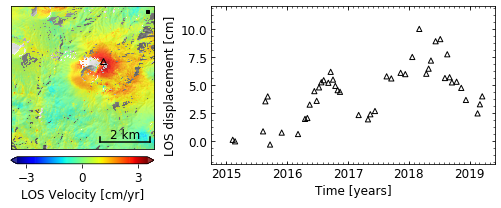

In [2]:
# Plot Velocity with POI displacement timeseries
print_msg = False

# read ts data
obj = timeseries(ts_file)
obj.open(print_msg=print_msg)
dates = ptime.date_list2vector(obj.dateList)[0]

lat, lon = 31.9172, 130.8887
coord = ut.coordinate(obj.metadata)
y, x = coord.geo2radar(lat, lon)[0:2]
print('y/x: {}/{}'.format(y, x))
d_ts = np.squeeze(readfile.read(ts_file, box=(x, y, x+1, y+1))[0]) * 100.

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])
# plot velocity using view.py
cmd = 'view.py {} velocity --mask {} --dem {} --dem-nocontour '.format(vel_file, mask_file, dem_file)
cmd += ' --sub-lon 130.85 130.91 --sub-lat 31.88 31.94 '
cmd += ' -c jet -v -3.5 3.5 --notitle --fontsize 12 --ref-size 3 '
cmd += ' --cbar-loc bottom --cbar-nbins 3 --cbar-ext both --cbar-size 5% '
cmd += ' --lalo-step 0.2 --lalo-loc 1 0 1 0 '
cmd += ' --scalebar 0.3 0.80 0.05 --scalebar-pad 0.05 --noverbose'
d_v, atr ,inps = view.prep_slice(cmd)
inps.cbar_label = 'LOS Velocity [cm/yr]'
axs[0], inps, im, cbar = view.plot_slice(axs[0], d_v, atr, inps)

# plot point of interest
axs[0].plot(lon, lat, "k^", mfc='none', mew=1., ms=6)
# plot point time-series
axs[1].scatter(dates, d_ts, marker='^', edgecolor='k', facecolors='none', s=3**3)
pp.auto_adjust_xaxis_date(axs[1], obj.yearList, fontsize=font_size)
axs[1].set_xlabel('Time [years]', fontsize=font_size)
axs[1].set_ylabel('LOS displacement [cm]', fontsize=font_size)
axs[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
axs[1].tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
axs[1].set_ylim(-2,12)
fig.subplots_adjust(wspace=-0.5)
fig.tight_layout()

# output
out_file = os.path.join(data_dir, 'ShinmoedakeAlos2DT23_POI.png')
print('save figure to file', out_file)
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [33]:
!save_roipac.py timeseries_ERA5_ramp_demErr.h5 20150223_20161031
!mask.py 20150223_20161031.unw -m maskTempCoh.h5
!subset.py 20150223_20161031_msk.unw -o Alos2DT23_20150223_20161031_msk.unw -r ../../Model/Shinmoedake/data/AlosDT73_20081127_20100302_msk.unw

read 20150223_20161031 from file timeseries_ERA5_ramp_demErr.h5
converting range to phase
write 20150223_20161031.unw
write 20150223_20161031.unw.rsc
masking 20150223_20161031 from 20150223_20161031.unw ...
write 20150223_20161031_msk.unw
write 20150223_20161031_msk.unw.rsc
Done.
using subset info from ../../Model/Shinmoedake/AlosDT73_20081127_20100302_msk.unw
------------------------------
subset .unw file: 20150223_20161031_msk.unw ...
data   range in y/x: (0, 0, 541, 541)
subset range in y/x: (161, 215, 487, 541)
data   range in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
subset range in lat/lon: (130.84972219249997, 31.9402778175, 130.91009250249996, 31.8799075075)
writing >>> Alos2DT23_20150223_20161031_msk.unw
subsetting 20150223_20161031_msk from 20150223_20161031_msk.unw ...
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 161/215/487/541
update Y/X_FIRST
update REF_Y/X
write Alos2DT23_20150223_20161031_msk.unw
write Alos2D

In [44]:
!save_roipac.py temporalCoherence.h5 -o 20150223_20161031.cor
!subset.py 20150223_20161031.cor -o Alos2DT23_20150223_20161031.cor -r ../../Model/Shinmoedake/data/AlosDT73_20081127_20100302_msk.unw

read None from file temporalCoherence.h5
write 20150223_20161031.cor
write 20150223_20161031.cor.rsc
using subset info from ../../Model/Shinmoedake/data/AlosDT73_20081127_20100302_msk.unw
------------------------------
subset .cor file: 20150223_20161031.cor ...
data   range in y/x: (0, 0, 541, 541)
subset range in y/x: (161, 215, 487, 541)
data   range in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
subset range in lat/lon: (130.84972219249997, 31.9402778175, 130.91009250249996, 31.8799075075)
writing >>> Alos2DT23_20150223_20161031.cor
subsetting 20150223_20161031 from 20150223_20161031.cor ...
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 161/215/487/541
update Y/X_FIRST
update REF_Y/X
write Alos2DT23_20150223_20161031.cor
write Alos2DT23_20150223_20161031.cor.rsc


In [49]:
!save_roipac.py inputs/geometryGeo.h5 height -o Alos2.hgt
!subset.py Alos2.hgt -r ../../Model/Shinmoedake/data/AlosDT73_20081127_20100302_msk.unw -o ../../Model/Shinmoedake/data/Alos2.hgt

read height from file inputs/geometryGeo.h5
write Alos2.hgt
write Alos2.hgt.rsc
using subset info from ../../Model/Shinmoedake/data/AlosDT73_20081127_20100302_msk.unw
------------------------------
subset .hgt file: Alos2.hgt ...
data   range in y/x: (0, 0, 541, 541)
subset range in y/x: (161, 215, 487, 541)
data   range in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
subset range in lat/lon: (130.84972219249997, 31.9402778175, 130.91009250249996, 31.8799075075)
writing >>> ../../Model/Shinmoedake/data/Alos2.hgt
subsetting Alos2 from Alos2.hgt ...
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 161/215/487/541
update Y/X_FIRST
write ../../Model/Shinmoedake/data/Alos2.hgt
write ../../Model/Shinmoedake/data/Alos2.hgt.rsc


In [48]:
0.000185185 * 108e3

19.99998

tsview.py timeseries_ERA5_ramp_demErr.h5 --wrap --wrap-range -5 5 --ylim -2 10 --ref-date 20150223 -n 20 --lalo 31.9176 130.8889
open timeseries file: timeseries_ERA5_ramp_demErr.h5
exclude date:['20150810', '20151130', '20160725', '20180806', '20180903', '20181015', '20181210']
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 541, 541)
subset coverage in y/x: (0, 0, 541, 541)
data   coverage in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
subset coverage in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
------------------------------------------------------------------------
reading timeseries from file timeseries_ERA5_ramp_demErr.h5 ...
reference to pixel: (270, 238)
reference to date: 20150223
read mask from file: maskTempCoh.h5
data    range: [-24.592213, 26.284302] cm
display range: [-5.0, 5.0] cm
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projection: cyl
boundary

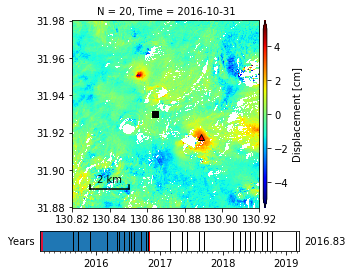

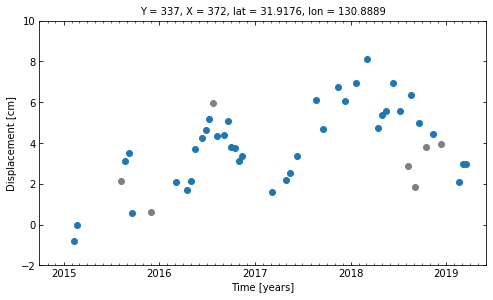

In [2]:
cmd = 'timeseries_ERA5_ramp_demErr.h5 --wrap --wrap-range -5 5 --ylim -2 10 --ref-date 20150223 -n 20 --lalo 31.9176 130.8889'
tsview.main(cmd.split())